In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from scipy.stats.kde import gaussian_kde
import scipy.signal as signal
%matplotlib inline
from IPython.html import widgets
from IPython.html.widgets import interact,fixed

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
execfile('/notebooks/assay-explorer/src/display_utils.py')

In [3]:
filepath = '/notebooks/moldev-data/analyzed/07-15-2015/ssC PNA.csv'
cells = pd.read_csv(filepath)

In [4]:
intensity = cells['NucIntegrated Intensity_Avg'].values

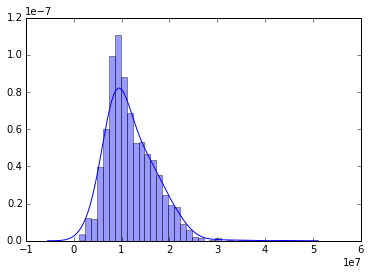

In [5]:
interact(lambda xs,bandwidth: sns.distplot(xs,kde_kws = {'bw':bandwidth,'kernel':'gau'}),
         xs = fixed(intensity),
         bandwidth = widgets.FloatSlider(min = 0,
                                         max = max(intensity)/20,
                                         step = np.mean(intensity)/50,
                                         value = np.mean(intensity)));

In [6]:
def get_thresholds(vals,bw):
    pdf = gaussian_kde(vals,bw_method=bw)
    x = np.linspace(min(vals),max(vals),1000)
    y = pdf(x)
    ddx = np.diff(np.diff(y))
    peak = np.argmin(ddx)
    indices = [yi for yi in signal.argrelmax(ddx)[0] if yi > peak]
    return (x[indices],pdf(x[indices]))

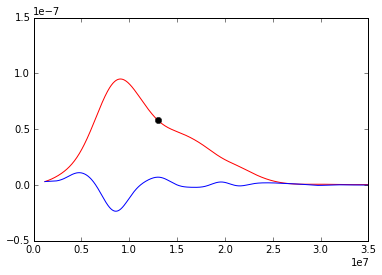

In [10]:

def f(bw):
    my_pdf = gaussian_kde(intensity,bw_method=bw)
    x = np.linspace(min(intensity),max(intensity),1000)
    p1 = np.diff(my_pdf(x))
    p2 = np.diff(p1) * 10**3
    plt.plot(x,my_pdf(x),'r') # distribution function
    plt.plot(x[:-2],p2,'b')
    
#     thresh_x,thresh_y = get_threshold(intensity,bw)
#     plt.plot(thresh_x,thresh_y,'ko')
    thresh_xs,thresh_ys = get_thresholds(intensity,bw)
    plt.plot(thresh_xs[0],thresh_ys[0],'ko')
    plt.axis([0,3.5e7,-0.5e-7,1.5e-7])

    return my_pdf
#     plt.hist(intensity,normed=1,alpha=.3,bins=200) # histogram

interact(f,bw=widgets.FloatSlider(min=0.2,max=0.6,step=0.01,value=0.5));

In [54]:
def get_threshold(vals,bw):
    pdf = gaussian_kde(vals,bw_method=bw)
    x = np.linspace(min(vals),max(vals),1000)
    y = pdf(x)
    ddx = np.diff(np.diff(y))
    peak = np.argmin(ddx)
    index = min([yi for yi in signal.argrelmax(ddx)[0] if yi > peak])
    return (x[index],pdf(x[index])[0])

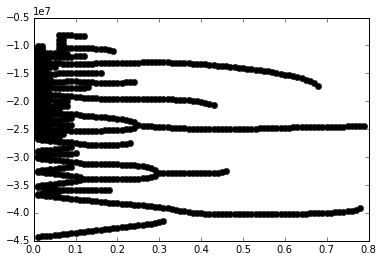

In [64]:
bws = np.arange(0.01,0.8,0.01)
results = [get_thresholds(intensity,bw)[0] for bw in bws]

for bw,result in zip(bws,results):
    plt.plot([bw]*len(result),result * -1,'ko')

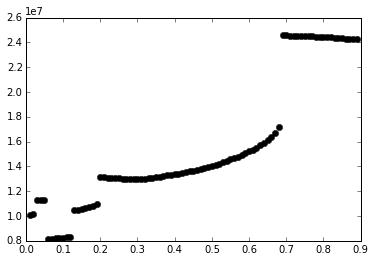

In [66]:
bws = np.arange(0.01,0.9,0.01)
results = np.array([get_threshold(intensity,bw) for bw in bws])
plt.plot(bws,results,'ko')

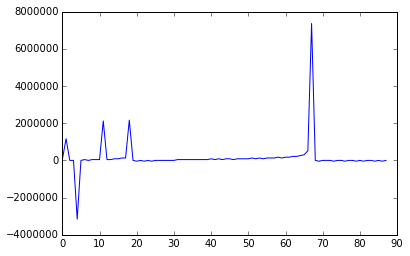

In [67]:
plt.plot(np.diff(results))

In [58]:
# [Float] -> Float
def get_threshold(intensity,bw = 0.35):
    """ Given an array of intensities, find the intensity 
        threshold separating the G1 peak from the S/G2 peak. """
    kde_fit = gaussian_kde(intensity,bw)
    x = np.linspace(min(intensity),
                    max(intensity),
                    1000)
    y = kde_fit(x)
    ddx = np.diff(np.diff(y)) # second derivative of fit
    peak = np.argmin(ddx) # most frequent intensity 
    index = min([yi for yi in signal.argrelmax(ddx)[0] if yi > peak])
    threshold = x[index]
    return threshold

In [68]:
threshs = map(lambda x: (x[0],get_threshold(x[1]['NucIntegrated Intensity_Avg'])), cells.groupby('Condition'))

In [69]:
threshs

[('ssC PNA ssC 12.5 nM 143B', 14065835.792792793),
 ('ssC PNA ssC 12.5 nM U2OS', 11668791.448448448),
 ('ssC PNA ssC 25 nM 143B', 15571072.432432432),
 ('ssC PNA ssC 25 nM U2OS', 12526201.852852853),
 ('ssC PNA ssC 50 nM 143B', 16817878.082082085),
 ('ssC PNA ssC 50 nM U2OS', 11418294.158158159),
 ('ssC PNA ssC 6.25 nM 143B', 12357265.941941943),
 ('ssC PNA ssC 6.25 nM U2OS', 10091842.552552553)]

In [74]:
def get_bw_plot(condition):
    bws = np.arange(0.01,0.9,0.01)
    intensity = filter_rows(cells,'Condition',condition)['NucIntegrated Intensity_Avg']
    results = np.array([get_threshold(intensity,bw) for bw in bws])
    plt.plot(bws,results,'ko')
    plt.axis([0,0.9,0.5e7,2.5e7])

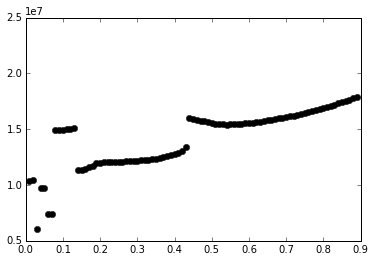

In [75]:
interact(get_bw_plot,
         condition = widgets.Select(options = cells.Condition.unique().tolist()));